In [129]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import os
from keras import backend as K
from keras.layers import Conv2D, Dropout, LSTM, BatchNormalization, Input,Activation, MaxPool2D, Flatten, Dense,TimeDistributed
from keras.models import Model, load_model
from keras import metrics 
from sklearn.metrics import confusion_matrix 

In [6]:
VIDEOS_DIR = '../Videos/'
IMAGES_DIR = '../Images/'

In [5]:
classes = ['Kicking', 'Riding-Horse', 'Running', 'SkateBoarding', 'Swing-Bench', 'Lifting', 'Swing-Side', 'Walking', 'Golf-Swing']

In [7]:
class_to_index = {}
for i in range(len(classes)):
    class_to_index[classes[i]] = i
class_to_index

{'Golf-Swing': 8,
 'Kicking': 0,
 'Lifting': 5,
 'Riding-Horse': 1,
 'Running': 2,
 'SkateBoarding': 3,
 'Swing-Bench': 4,
 'Swing-Side': 6,
 'Walking': 7}

In [8]:
videos = []
for x in classes:
    videos.append(list(os.listdir(VIDEOS_DIR+x+'/')))
print(videos)

[['014', '009', '005', '011', '010', '003', '012', '006', '013', '004', '016', '001', '007', '002', '017', '015'], ['009', '005', '010', '003', '006', '004', '001', '007', '008', '002'], ['009', '005', '010', '006', '004', '001', '007', '008', '002'], ['009', '005', '010', '003', '006', '004', '001', '007', '008', '002'], ['014', '009', '005', '011', '010', '003', '012', '006', '013', '004', '016', '001', '007', '008', '002', '017', '015'], ['005', '003', '004', '001', '002'], ['009', '005', '011', '010', '003', '006', '004', '001', '007', '008', '002'], ['014', '009', '005', '011', '010', '018', '003', '012', '006', '013', '004', '016', '001', '019', '007', '008', '002', '017', '015'], ['014', '009', '005', '011', '010', '003', '012', '006', '013', '004', '001', '007', '008', '002']]


In [9]:
def load_image(path,image_size):
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size)
    return image

In [17]:
def build_dataset(image_size, images_per_video = 10):
    X_train_images = []
    Y_train_images = []
    for i in range(len(classes)):
        cls = classes[i]
        for j in range(len(videos[i])):
            vid = videos[i][j]
            video_r = VIDEOS_DIR+cls+'/'+ vid +'/'
            image_r = IMAGES_DIR+cls+'/'+ vid +'/'
            filelist = list(os.listdir(image_r))
            #print(sorted(filelist))
            X_train_images_video = []
            for fichier in filelist:
                if fichier.endswith(".png"):
                    image = load_image(image_r+fichier,image_size)
                    X_train_images_video.append(image)
            permutation = np.random.permutation(len(X_train_images_video))
            X_train_images_video = np.array(X_train_images_video)[permutation]
            no_of_images = min(images_per_video, len(X_train_images_video))
            X_train_images += list(X_train_images_video[:no_of_images])
            Y_train_images += [i]*no_of_images
    return np.array(X_train_images), np.array(Y_train_images)

In [18]:
X, Y = build_dataset((172, 172))

In [19]:
X.shape

(1097, 172, 172, 3)

In [20]:
Y.shape

(1097,)

In [43]:
def transform_image(image):
    size = image.shape[0] 
    t1x, t1y = np.random.randint(low=-10, high=0, size=2)
    t2x, t2y = np.random.randint(low=0, high=10, size=2)
    translation_matrix1 = np.float32([[1,0,t1x], [0,1,t1y]])
    translation_matrix2 = np.float32([[1,0,t2x], [0,1,t2y]])
    img1 = cv2.warpAffine(image, translation_matrix1, (size, size))
    img2 = cv2.warpAffine(image, translation_matrix2, (size, size))
    black1 = cv2.inRange(img1, np.array([0, 0, 0], dtype = np.uint8), np.array([1, 1, 1], dtype = np.uint8))
    black2 = cv2.inRange(img2, np.array([0, 0, 0], dtype = np.uint8), np.array([1, 1, 1], dtype = np.uint8))
    res1 = cv2.bitwise_and(img1, img1, black1)
    res2 = cv2.bitwise_and(img2, img2, black2)
    res1[black1 == 255] = (255, 255, 255)
    res2[black2 == 255] = (255, 255, 255)
    res1 = cv2.flip(res1,1)
    #plt.imshow(res1)
    #plt.show()
    #plt.imshow(res2)
    #plt.show()
    return res1, res2

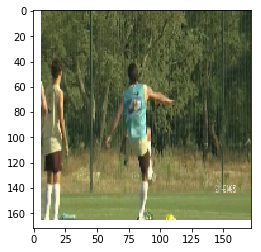

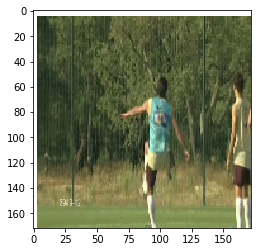

(array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 39,  55,  36],
         [ 41,  55,  35],
         [ 33,  47,  26]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 40,  54,  35],
         [ 38,  54,  34],
         [ 27,  41,  21]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 40,  54,  35],
         [ 46,  60,  41],
         [ 30,  44,  26]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [40]:
transform_image(X[26])

In [44]:
X_transformed = []
Y_transformed = []
for i in range(len(X)):
    image = X[i]
    im1, im2 = transform_image(image)
    X_transformed.append(im1)
    X_transformed.append(im2)
    Y_transformed.append(Y[i])
    Y_transformed.append(Y[i])

In [46]:
len(X_transformed)
len(Y_transformed)

2194

In [47]:
X = list(X) + X_transformed
Y = list(Y) + Y_transformed

In [48]:
del X_transformed
del Y_transformed

In [49]:
X = np.array(X)
Y = np.array(Y)

In [50]:
X.shape

(3291, 172, 172, 3)

In [51]:
Y.shape

(3291,)

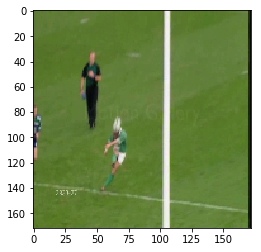

Kicking


In [80]:
r = np.random.randint(len(X))
plt.imshow(X[r])
plt.show()
print(classes[Y[r]])

In [103]:
#Dropout Hyperparameters
def build_model(input_shape):
    X_input = Input(input_shape, name = "Input")
    
    X = BatchNormalization(name = 'BatchNorm_1')(X_input)
    
    X = Conv2D(32, (7, 7), strides = (4, 4), name="Conv_1a", padding="same")(X)
    X = Activation('relu')(X)
    
    X = Conv2D(32, (3, 3), name = "Conv_1b", padding="same")(X)
    X = Activation('relu')(X)
    
    X = MaxPool2D((2, 2), name = "Pool_1")(X)
    X = Dropout(0.2)(X)
    
    X = Conv2D(32, (3, 3), name ="Conv_2", padding = "same")(X)
    X = Activation('relu')(X)
    
    X = MaxPool2D((2, 2), name = "Pool_2")(X)
    X = Dropout(0.2)(X)
    
    X = Conv2D(32, (3, 3), name ="Conv_3", padding = "same")(X)
    X = Activation('relu')(X)
    
    X = MaxPool2D((2, 2), name = "Pool_3")(X)
    X = Dropout(0.2)(X)
    
    X = Conv2D(8,(1,1), name='Conv_1x1', activation='relu')(X)
    X = Flatten()(X)
    X = Dropout(0.3)(X)
    
    return Model(X_input, X)

In [104]:
model = build_model((172, 172, 3))

In [106]:
def CNN_model(prev_model):
    X = Dense(9,activation='softmax',name='final')(prev_model.output)
    return Model(prev_model.input, X)

In [107]:
cnn = CNN_model(model)
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 172, 172, 3)       0         
_________________________________________________________________
BatchNorm_1 (BatchNormalizat (None, 172, 172, 3)       12        
_________________________________________________________________
Conv_1a (Conv2D)             (None, 43, 43, 32)        4736      
_________________________________________________________________
activation_23 (Activation)   (None, 43, 43, 32)        0         
_________________________________________________________________
Conv_1b (Conv2D)             (None, 43, 43, 32)        9248      
_________________________________________________________________
activation_24 (Activation)   (None, 43, 43, 32)        0         
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 21, 21, 32)        0         
__________

In [108]:
cnn.compile(loss='categorical_crossentropy', 
            metrics=['accuracy'], 
            optimizer='adam')

In [110]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [111]:
Y_one = convert_to_one_hot(Y, 9) 

In [113]:
def permute(X,Y):
    train_size = X.shape[0]
    permutation_train = np.random.permutation(train_size)
    X = X[permutation_train]
    Y = Y[permutation_train]
    return X,Y

In [114]:
X, Y_one = permute(X, Y_one)

In [115]:
split = int(0.9*len(X))
print(split)
X_train, X_test, Y_train, Y_test = X[:split], X[split: ], Y_one[:split], Y_one[split:]

2961


In [116]:
X_train.shape, Y_train.shape

((2961, 172, 172, 3), (2961, 9))

In [122]:
X_test.shape, Y_test.shape

((330, 172, 172, 3), (330, 9))

In [157]:
cnn = load_model('./models/Conv/Augmented_valacc89.h5')

In [153]:
cnn.fit(X_train, Y_train, epochs = 1, batch_size = 256, validation_split = 0.08)

Train on 2724 samples, validate on 237 samples
Epoch 1/1
2724/2724 [==============================] - 14s 5ms/step - loss: 0.4656 - acc: 0.8308 - val_loss: 0.3330 - val_acc: 0.8987


In [158]:
cnn.evaluate(X_test, Y_test)

330/330 [==============================] - 2s 7ms/step


[0.41707043449083964, 0.8909090909090909]

In [160]:
y_pred = np.argmax(cnn.predict(X_test), axis =-1)
y_actual = np.argmax(Y_test, axis=-1)

In [161]:
confusion_matrix(y_true = y_pred, y_pred = y_actual)

array([[40,  0,  0,  0,  0,  0,  0,  8,  2],
       [ 0, 26,  1,  1,  0,  0,  0,  5,  0],
       [ 1,  1, 26,  0,  0,  0,  0,  2,  0],
       [ 0,  0,  4, 31,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0, 45,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  9,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 29,  0,  0],
       [ 1,  2,  4,  0,  0,  0,  0, 53,  0],
       [ 2,  0,  0,  0,  0,  0,  0,  0, 35]])

In [147]:
cnn.save('./models/Conv/Augmented_valacc89.h5')